# installations

In [ ]:
pip install TabularDataInvestigation

# Packages

In [29]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
from TabularDataInvestigation import tdi
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

## Data Checking

In [3]:
def investiate_df(df):
  print("\n-----------Which indexes are containing nulls?--------------")
  returned_df = tdi.find_index_for_null_values(df)
  print(returned_df)
  print("\n---------- Is there any invalid value which is the cuase of misleading DataTypes?---------------")
  returned_df = tdi.check_error_data_types(df)
  print(returned_df)
  print("\n---------- Is there any categorical variable which have less category to split?---------------")
  returned_df = tdi.check_num_of_min_category(df, minimum_threshold=1)
  print(returned_df)
  print("\n---------- Is there any categorical variable which have only one category of data?---------------")
  returned_df = tdi.check_col_with_one_category(df)
  print(returned_df)
  print("\n---------- Is there any variable which have special characters?---------------")
  returned_df = tdi.find_special_char_index(df)
  print(returned_df)
  print("\n---------- Is there any variables those are having the same values?---------------")
  returned_df =  tdi.duplicate_columns(df)
  print(returned_df)
  print("\n---------- Is there variables those are correlated more than 90% ? which can cuases data leakage issue if it is with the target column---------------")
  returned_df = tdi.correlated_columns(df, return_type='dataframe')
  print(returned_df)


In [4]:
df = pd.read_csv("bmw_raw_train_data.csv")

In [5]:
investiate_df(df)


-----------Which indexes are containing nulls?--------------
Empty DataFrame
Columns: []
Index: []

---------- Is there any invalid value which is the cuase of misleading DataTypes?---------------
Empty DataFrame
Columns: [columns, error_data, error_index]
Index: []

---------- Is there any categorical variable which have less category to split?---------------
Empty DataFrame
Columns: [columns, category, index]
Index: []

---------- Is there any categorical variable which have only one category of data?---------------
Empty DataFrame
Columns: [columns, category_name]
Index: []

---------- Is there any variable which have special characters?---------------
        columns                                has_special_char_at
0         model                                                 []
1         price                                                 []
2  transmission  [68, 69, 70, 129, 133, 135, 136, 138, 139, 141...
3       mileage                                                 []


# Data Visualization

In [6]:
df.columns

Index(['model', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg',
       'engineSize'],
      dtype='object')

In [7]:
def EDA_trace_generator(select_x, select_series, each_series_type, result, operation=None, filter=None, sorting=None, select_z=[]):
  trace_dict = {}
  result = result.reset_index()
  if operation is not None:
      if len(select_series) < 1:
          output = pd.DataFrame(result[select_x].value_counts())
          output = output.rename(columns={0: "select_series"})
          output = output.reset_index()

      else:
          if len(select_z) < 1:
            output = result[select_x + select_series]
            output = pd.pivot_table(output,index=select_x, values=select_series, aggfunc=operation)
            output = output.reset_index()

          else:
            output = result[select_x + select_series + select_z]
            output = pd.pivot_table(output, index= select_x + select_z, values=select_series, aggfunc=operation)
            output = output.reset_index()


  else:
      if len(select_z) < 1:
            output = result[select_x + select_series].copy()

      else:
          output = result[select_x + select_series + select_z]

  if len(select_z) > 0:

      for depth_col in output[select_z].columns:

        if output[depth_col].dtypes == 'O':

          for depth_col_category in output[depth_col].unique():
            output_temp = output[output[depth_col]== depth_col_category].copy()  #trace separation
            # print("Output df\n\n",output_temp)
            for select_z_col in output_temp[select_z].columns:

              for select_series_col in output_temp[select_series].columns:
                  trace_dict.update({select_series_col+"_"+depth_col_category: {"x": output_temp[select_x[0]].values.tolist(),
                                                          "y": output_temp[select_series_col].values.tolist(),
                                                          "z": output_temp[select_z_col].values.tolist(),
                                                          'type': each_series_type[select_series_col]}})
        else:
          # print("Output df\n\n",output)
          for select_z_col in output[select_z].columns:

            for select_series_col in output[select_series].columns:
                  trace_dict.update({select_series_col: {"x": output[select_x[0]].values.tolist(),
                                                          "y": output[select_series_col].values.tolist(),
                                                          "z": output[select_z_col].values.tolist(),
                                                          'type': each_series_type[select_series_col]}})

      print("3D response\n\n",trace_dict)
  else:
      # print("Output df\n\n",output)
      for col in output.columns[1:]:
          trace_dict.update({col: {"x": output[select_x[0]].values.tolist(), "y": output[col].values.tolist(),
                                    'type': each_series_type[col]}})
      print("2D response\n\n",trace_dict)
  return trace_dict


In [ ]:
eda_trace = EDA_trace_generator(select_x=["index"], select_series = ["mileage","price"], each_series_type={'price' : 'line', 'mileage':'line'}, result=df, operation=None, filter=None, sorting=None, select_z=[])


In [9]:
def plot_generated_trace(trace):
  fig, ax = plt.subplots()
  for each_trace in eda_trace:
    current_trace = eda_trace[each_trace]
    print(current_trace["type"])
    if current_trace['type'] == 'bar':
      # Create a bar plot
      sns.barplot(x=current_trace['x'], y=current_trace['y'], ax=ax, label=each_trace)
    if current_trace['type'] == 'line':
      # Create a bar plot
      sns.lineplot(x=current_trace['x'], y=current_trace['y'], ax=ax, label=each_trace)
    if current_trace['type'] == 'scatter':
      # Create a bar plot
      sns.scatterplot(x=current_trace['x'], y=current_trace['y'], ax=ax, label=each_trace)
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.legend()

  # Display the plot
  plt.show()

**Categorical column categories counting**

In [10]:
def find_date_col(data):
    """
    This function finds the datetime column from the all columns
    and sets the datetime column as index
    Args:
        data: the input file
    Returns:
        date_col (str): name of the datetime column
        data: after the conversion from string to datetime object
    """
    date_col = []
    for col in data.columns:
        if data[col].dtype == 'object':
            try:
                data[col] = pd.to_datetime(data[col])
                date_col.append(col)
            except ValueError:
                pass

    df_datetime = data.select_dtypes(["datetime","datetimetz","timedelta"])

    if not date_col:
        date_col = list(df_datetime.columns)
    return date_col, data

In [11]:
def categorical_col_ploting(df):
  date_col, checked_df = find_date_col(df)
  # Identify categorical columns
  categorical_columns = checked_df.select_dtypes(include=['object'])
  # Create a countplot
  for cat_col in categorical_columns.columns:
      plt.figure(figsize=(5, 3))  # Set the figure size
      sns.countplot(data=categorical_columns, x=cat_col)

      # Add labels and title
      plt.xlabel(cat_col)
      plt.ylabel('Count')
      plt.title(f'Count of Categories in {cat_col}')
      # Show the plot
      plt.show()

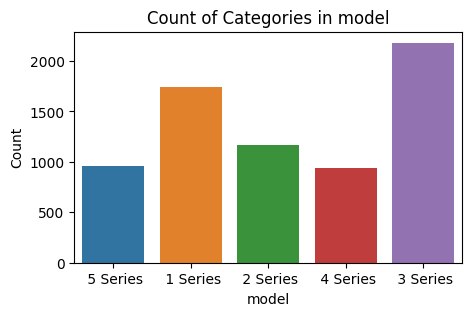

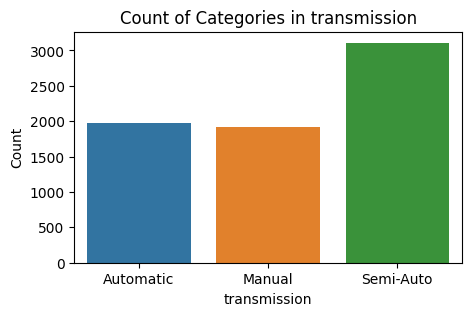

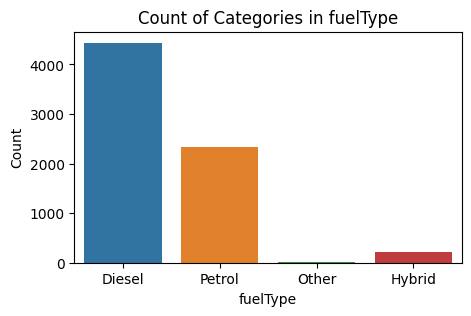

In [12]:
# Create a countplot
categorical_col_ploting(df)






**scatter plots with target columns (if regression)**

In [13]:
def scatter_col_ploting_depending_with_target(df, target_col):
  date_col, checked_df = find_date_col(df)
  # Identify categorical columns
  numeric_columns = checked_df.select_dtypes(include=['number'])
  # Create a countplot
  for num_col in numeric_columns.columns:
      plt.figure(figsize=(5, 3))  # Set the figure size
      sns.scatterplot(x=numeric_columns[target_col], y=numeric_columns[num_col], label=num_col)

      # Add labels and title
      plt.xlabel(target_col)
      plt.ylabel(num_col)
      plt.title(f'distribution between {target_col} and {num_col} ')
      # Show the plot
      plt.show()

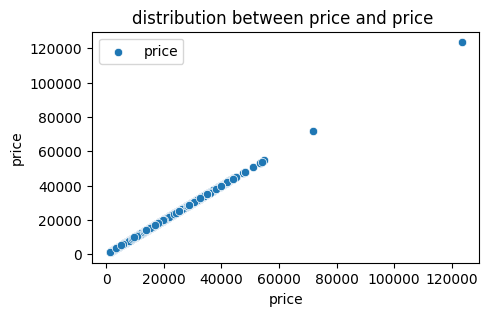

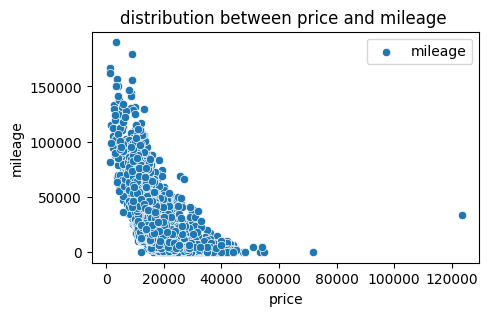

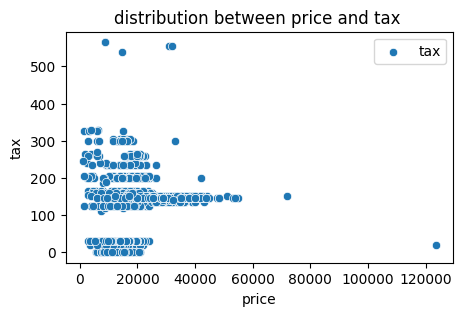

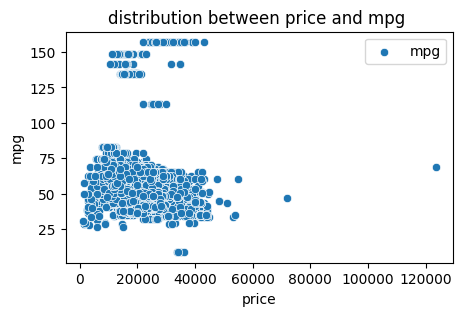

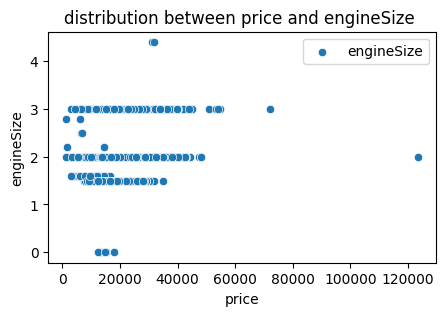

In [14]:
scatter_col_ploting_depending_with_target(df, target_col='price')

# Label Encoding

In [99]:
def label_encoder(df):
  date_col, checked_df = find_date_col(df)
  # Identify categorical columns
  categorical_columns = checked_df.select_dtypes(include=['object'])
  label_encoder = LabelEncoder()
  for cat_col in categorical_columns.columns:
    label_encoder.fit(categorical_columns[cat_col])
    with open(cat_col+'_label_encoder.pkl', 'wb') as f:
      pickle.dump(label_encoder, f)
    checked_df[cat_col] = label_encoder.transform(categorical_columns[cat_col])

  return checked_df, label_encoder

In [100]:
def label_decoder(encoded_df, categorical_cols):

  for cat_col in encoded_df[categorical_cols].columns:
    with open(cat_col+'_label_encoder.pkl', 'rb') as f:
      loaded_label_encoder = pickle.load(f)
    encoded_df[cat_col] = loaded_label_encoder.inverse_transform(encoded_df[cat_col])
  return encoded_df



In [101]:
def loaded_label_encoder(encoded_df, categorical_cols):
  for cat_col in categorical_cols:
    with open(cat_col+'_label_encoder.pkl', 'rb') as f:
      loaded_label_encoder = pickle.load(f)
    encoded_df.loc[:,cat_col] = loaded_label_encoder.transform(encoded_df[cat_col])

  return encoded_df

In [18]:
encoded_df, _ = label_encoder(df)


In [19]:
decoded_df = label_decoder(encoded_df, ['model', 'transmission', 'fuelType',])

In [ ]:
encodedWithLodedModel_df = loaded_label_encoder(df, ['model', 'transmission', 'fuelType',])

# Scaling

In [21]:
def scaling_encoder(df, numeric_cols):
  scaler = MinMaxScaler()
  for num_col in numeric_cols:
    model=scaler.fit(df[[num_col]])
    with open(num_col+'_scaling_encoder.pkl', 'wb') as f:
      pickle.dump(model, f)
    df.loc[:,num_col] = model.transform(df[[num_col]])
  return df

In [22]:
def scaling_with_loaded_encoder(df, numeric_cols):
  for num_col in numeric_cols:
    with open(num_col+'_scaling_encoder.pkl', 'rb') as f:
      scaling_loaded_encoder = pickle.load(f)
    df.loc[:,num_col] = scaling_loaded_encoder.transform(df[[num_col]])
  return df

In [23]:
scaled_df = scaling_encoder(df, ['price','mpg','mileage'])

# Accuraccy Matrics

In [110]:
from sklearn.metrics import accuracy_score

def calculate_accuracy_matric(test_data, test_target, model):

    test_predictions = model.predict(test_data)
    # Calculate acc testing data
    test_acc = accuracy_score(test_target, test_predictions)

    return test_acc

# Feature importance with ML Models

In [28]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
def get_variable_importance(model, X, y, method='auto', n_repeats=30, random_state=42):
    if method == 'auto':
        if hasattr(model, "feature_importances_"):
            method = 'tree'
        else:
            method = 'permutation'

    if method == 'tree':
        if isinstance(model, ( RandomForestClassifier, XGBClassifier)):
            return model.feature_importances_
        else:
            raise ValueError("Tree-based feature importance is only available for specific models (Random Forest, XGBoost, LightGBM).")

    if method == 'permutation':
        result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state)
        return result.importances_mean

    raise ValueError("Invalid method for variable importance. Use 'tree' or 'permutation'.")

# ML Algorithms

In [35]:

class ML_Models:
  def __init__(self):
    print("---ML_Models class defined")
  def model_LR(self, X, y, stage='training', best_params={}):
      if stage=='training':
        # Define the parameter grid for Grid Search
        param_grid = {
            'fit_intercept': [True, False]
        }

        # Create a Linear Regression model
        lr = LogisticRegression()
        print("Training with Logistic Regression . . .")
        # Create a Grid Search Cross-Validation object with MAE as the scoring metric
        grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)

        # Fit the model to the data and find the best hyperparameters
        grid_search.fit(X, y)

        # Get the best hyperparameters
        best_params = grid_search.best_params_

      # Train the model with the best hyperparameters
      best_lr_model = LogisticRegression(fit_intercept=best_params['fit_intercept'])
      best_lr_model.fit(X, y)

      var_imp = get_variable_importance(best_lr_model, X, y, method='auto', n_repeats=30, random_state=42)

      # Calculate cross-validation MAE
      cross_val_mae = cross_val_score(best_lr_model, X, y, scoring='accuracy', cv=3)

      print("Complete Training with Linear Regression . . .")
      return best_lr_model, best_params, cross_val_mae, var_imp

  def model_XGB(self, X, y, stage='training', best_params={}):
      if stage=='training':
        # Define the parameter grid for Grid Search
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1, 0.2]
        }
        print("Training with Xtreme Gradient Boosting . . .")
        # Create an XGBoost Regressor
        xgb = XGBClassifier()

        # Create a Grid Search Cross-Validation object with accuracy as the scoring metric
        grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3)

        # Fit the model to the data and find the best hyperparameters
        grid_search.fit(X, y)

        # Get the best hyperparameters
        best_params = grid_search.best_params_

      # Train the model with the best hyperparameters
      best_xgb_model = XGBClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'])
      best_xgb_model.fit(X, y)
      var_imp = get_variable_importance(best_xgb_model, X, y, method='auto', n_repeats=30, random_state=42)

      # Calculate cross-validation MAE
      cross_val_mae = cross_val_score(best_xgb_model, X, y, scoring='accuracy', cv=3)

      print("Complete Training with Xtreme Gradient Boosting . . .")
      return best_xgb_model, best_params, cross_val_mae, var_imp

  def model_RF(self, X, y, stage='training', best_params={}):
    if stage == 'training':
        # Define the parameter grid for Grid Search
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        print("Training with Random Forest . . .")
        # Create a Random Forest Regressor
        rf = RandomForestClassifier()

        # Create a Grid Search Cross-Validation object with MAE as the scoring metric
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3)

        # Fit the model to the data and find the best hyperparameters
        grid_search.fit(X, y)

        # Get the best hyperparameters
        best_params = grid_search.best_params_

    # Train the model with the best hyperparameters
    best_rf_model = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf']
    )
    best_rf_model.fit(X, y)
    var_imp = get_variable_importance(best_rf_model, X, y, method='auto', n_repeats=30, random_state=42)
    # Calculate cross-validation MAE
    cross_val_mae = cross_val_score(best_rf_model, X, y, scoring='accuracy', cv=3)

    print("Complete Training with Random Forest . . .")
    return best_rf_model, best_params, cross_val_mae, var_imp






# Feature Engineering

In [36]:
df = pd.read_csv("bmw_raw_train_data.csv")

In [48]:
df['transmission'].dtypes == 'O'

True

In [ ]:
cleaned_df = df.copy()
cleaned_df = cleaned_df.dropna()
target_column = 'transmission'
select_ml_algo = ['XGB']
#-------------------------------
feature_columns =  cleaned_df.drop(columns= [target_column]).columns

X = cleaned_df[feature_columns]
y = cleaned_df[target_column]

# extract numeric and categorical type column name
date_col, x_df = find_date_col(X)
if cleaned_df[target_column].dtypes == 'O':
  date_col, x_df = find_date_col(cleaned_df)


# Identify categorical columns
categorical_columns = x_df.select_dtypes(include=['object'])
categorical_columns = list(categorical_columns.columns)
print("-----",categorical_columns)
# Identify numeric columns
numeric_columns = x_df.select_dtypes(include=['number'])
numeric_columns = list(numeric_columns.columns)

test_size = 0.2

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

df_train = pd.concat([X_train, y_train],axis=1)
print("---train dataset shape = ",df_train.shape)
df_test = pd.concat([X_test, y_test],axis=1)
print("---test dataset shape = ",df_test.shape)

#---- label encoding--------
encoded_df_train, _ = label_encoder(df_train)
encoded_df_test = loaded_label_encoder(df_test, categorical_columns)

#---- scaling--------
encoded_df_train = scaling_encoder(encoded_df_train, numeric_columns)
scaled_df_train = encoded_df_train.copy()
encoded_df_test = scaling_with_loaded_encoder(encoded_df_test, numeric_columns)
scaled_df_test = encoded_df_test.copy()

# ---- separate the processed feature  and the target-----
X_train, X_test, y_train, y_test = scaled_df_train[feature_columns], scaled_df_test[feature_columns], scaled_df_train[target_column], scaled_df_test[target_column]

# -------- creating ml model object and make it dynamic based on algo names
validation_result_df = pd.DataFrame(columns = ['algorithm','train_score', 'test_score','best_params'])
variable_importance_df = pd.DataFrame(columns = ["algorithm"] + list(feature_columns))
ml_models_obj = ML_Models()

for ml_algo in select_ml_algo:
  algo_run_function = "model_"+ ml_algo
  extract_function = getattr(ml_models_obj, algo_run_function)
  # print(extract_function())
  fitted_model , best_params, train_score, var_importance = extract_function(X_train, y_train, stage='training')
  test_score = calculate_accuracy_matric(X_test, y_test, fitted_model)
  validation_result_df.loc[len(validation_result_df)] =  [ml_algo, np.mean(train_score), test_score, best_params]
  variable_importance_df.loc[len(variable_importance_df)] = [ml_algo] + list(var_importance)



In [57]:
import os

folder_name = "Feature_Engineering"
def create_folder(folder_name):
  # Check if the folder doesn't already exist
  if not os.path.exists(folder_name):
      os.makedirs(folder_name)
      print(f"Folder '{folder_name}' created successfully.")
  else:
      print(f"Folder '{folder_name}' already exists.")

create_folder(folder_name)

Folder 'Feature_Engineering' already exists.


In [58]:
validation_result_df.to_csv("Feature_Engineering/validation_result_FE.csv",index=False)

In [59]:
validation_result_df

,algorithm,train_score,test_score,best_params
0,XGB,0.692144,0.705714,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [60]:
variable_importance_df.to_csv("Feature_Engineering/variable_importance_FE.csv",index=False)

In [61]:
variable_importance_df

,algorithm,model,price,mileage,fuelType,tax,mpg,engineSize
0,XGB,0.144569,0.169397,0.072508,0.096913,0.081984,0.122236,0.312393


# PLoting Variable Importance

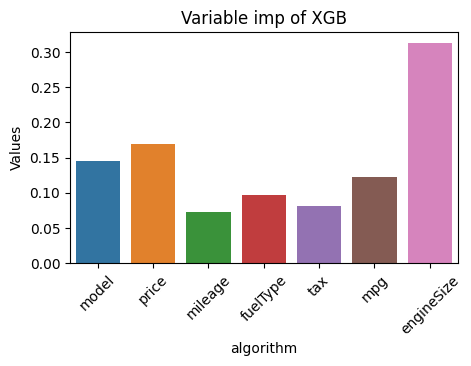

In [62]:
for ml_algo in variable_importance_df['algorithm'].values:
  data = variable_importance_df.T
  data = data.reset_index()
  # Set the first row as column names
  data.columns = data.iloc[0]
  # Drop the first row since it's now the column names
  data = data[1:]
  #----------plot the var imp-------------
  plt.figure(figsize=(5, 3))  # Set the figure size
  ax = sns.barplot(data, x='algorithm', y=ml_algo)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

  # Add labels and title
  plt.ylabel('Values')
  plt.title(f'Variable imp of {ml_algo}')
  # Show the plot
  plt.show()

# Decison Note and Select algo and final fetures

# Finalize the feature and deploy the model

In [88]:
def finalize_model(X_train, y_train, X_test, y_test, select_ml_algo, select_final_variables):
  # extract numeric and categorical type column name
  X_train = X_train[select_final_variables].copy()
  X_test = X_test[select_final_variables].copy()
  categorical_columns = ['model', 'transmission', 'fuelType']

  # df_train = pd.concat([X_train, y_train],axis=1)
  # print("---train dataset shape = ",df_train.shape)
  # df_test = pd.concat([X_test, y_test],axis=1)
  # print("---test dataset shape = ",df_test.shape)

  ml_models_obj = ML_Models()
  for ml_algo in select_ml_algo:
    algo_run_function = "model_"+ ml_algo
    extract_function = getattr(ml_models_obj, algo_run_function)
    # print(extract_function())
    loaded_best_params = dict(validation_result_df[validation_result_df['algorithm']==ml_algo]['best_params'])
    print(loaded_best_params)
    fitted_model , best_params, train_score, var_importance = extract_function(X_train, y_train, stage='finalize', best_params=loaded_best_params[0])
    create_folder("saved_models")
    joblib.dump(fitted_model, 'saved_models/'+ml_algo+'.sav')

    X_train["predicted_"+str(pd.DataFrame(y_train).columns[0])+ml_algo] = fitted_model.predict(X_train)
    X_train['train_or_test'] = 'train'
    X_test["predicted_"+str(pd.DataFrame(y_test).columns[0])+ml_algo] = fitted_model.predict(X_test)
    X_test['train_or_test'] = 'test'

    predicted_train_df = pd.concat([X_train, y_train], axis=1)
    predicted_test_df = pd.concat([X_test, y_test], axis=1)

    full_predicted_df = pd.concat([predicted_train_df, predicted_test_df])
    # categorical_columns = full_predicted_df.select_dtypes(include=['object'])
    # categorical_columns = list(categorical_columns.columns)
    # categorical_columns.remove('train_or_test')
    # print("------------",categorical_columns)
    categorical_columns = list(set(categorical_columns).intersection(set(list(full_predicted_df.columns))))
    print("------common------",categorical_columns)
    full_predicted_df = label_decoder(full_predicted_df, categorical_cols=categorical_columns)
    create_folder("predicted_data")
    full_predicted_df.to_csv("predicted_data/predicted_train_test.csv",index=False)


In [ ]:
#---------configuration-------
select_finalized_variables = ['mileage','mpg','price', 'fuelType']
select_final_ml_algo = ['XGB']
#-----------------------------------
finalize_model(X_train, y_train, X_test, y_test, select_final_ml_algo, select_finalized_variables)

# Prediction

In [104]:
pred_df = pd.read_csv("bmw_raw_train_data.csv")

In [105]:
pred_df = pred_df.drop(columns=['transmission'])

In [108]:
def predict(df):
  # extract numeric and categorical type column name
  date_col, checked_df = find_date_col(df)
  checked_df = checked_df[select_finalized_variables]
  # Identify categorical columns
  categorical_columns = checked_df.select_dtypes(include=['object'])
  categorical_columns = list(categorical_columns.columns)

  # Identify numeric columns
  numeric_columns = checked_df.select_dtypes(include=['number'])
  numeric_columns = list(numeric_columns.columns)

  #---- label encoding--------
  checked_df = loaded_label_encoder(checked_df, categorical_columns)

  #---- scaling--------
  checked_df= scaling_with_loaded_encoder(checked_df, numeric_columns)

  for ml_algo in select_final_ml_algo:
    loaded_model = joblib.load('saved_models/'+ml_algo+'.sav')
    df['predict_with_'+ml_algo] = loaded_model.predict(checked_df)
    with open(target_column+'_label_encoder.pkl', 'rb') as f:
      decoder = pickle.load(f)
    df['predict_with_'+ml_algo] = decoder.inverse_transform(df['predict_with_'+ml_algo])
  df.to_csv("predicted_data/production_predicted_data.csv",index=False)
  print("----Prediction is completed---")

In [ ]:
predict(pred_df)